In [1]:
from torch.utils.data import DataLoader, random_split

import T4sigWGAN as T4

In [2]:
total_dataset = T4.StockTimeSeriesDataset(T4.args.window_size)
train_size = int(0.9 * len(total_dataset))  # 90% for training
val_size = len(total_dataset) - train_size  # 10% for validation
train_dataset, val_dataset = random_split(total_dataset, [train_size, val_size])
train_dataloader = DataLoader(train_dataset, batch_size=T4.args.batch_size, shuffle=False, num_workers=2,
                              drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=T4.args.batch_size, shuffle=False, num_workers=2, drop_last=True)

In [3]:
Encoder = T4.LogSigRNNEncoder(**T4.encoder_config).to(T4.args.device)
Decoder = T4.TimesFormerDecoder(**T4.decoder_config).to(T4.args.device)
Supervisor = T4.ModernTCN(T4.supervisor_config).to(T4.args.device)
Generator = T4.LogSigRNNGenerator(**T4.logsig_config).to(T4.args.device)
Discriminator = T4.tailGANDiscriminator(T4.discriminator_config).to(T4.args.device)
model = T4.T4sigWGAN(Encoder, Decoder, Generator, Supervisor, Discriminator, T4.args.batch_size).to(T4.args.device)
trainer = T4.FinetuneTrainer(T4.args, model, train_dataloader, val_dataloader)

Total Parameters: 22759902


T4sigWGAN EP_train:0:   0%|| 0/25 [00:00<?, ?it/s]C:\Users\USER\anaconda3\envs\research\lib\site-packages\torch\nn\modules\conv.py:298: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\Convolution.cpp:744.)
  return F.conv1d(input, weight, bias, self.stride,
T4sigWGAN EP_valid:1: 100%|| 2/2 [00:02<00:00,  1.15s/it]


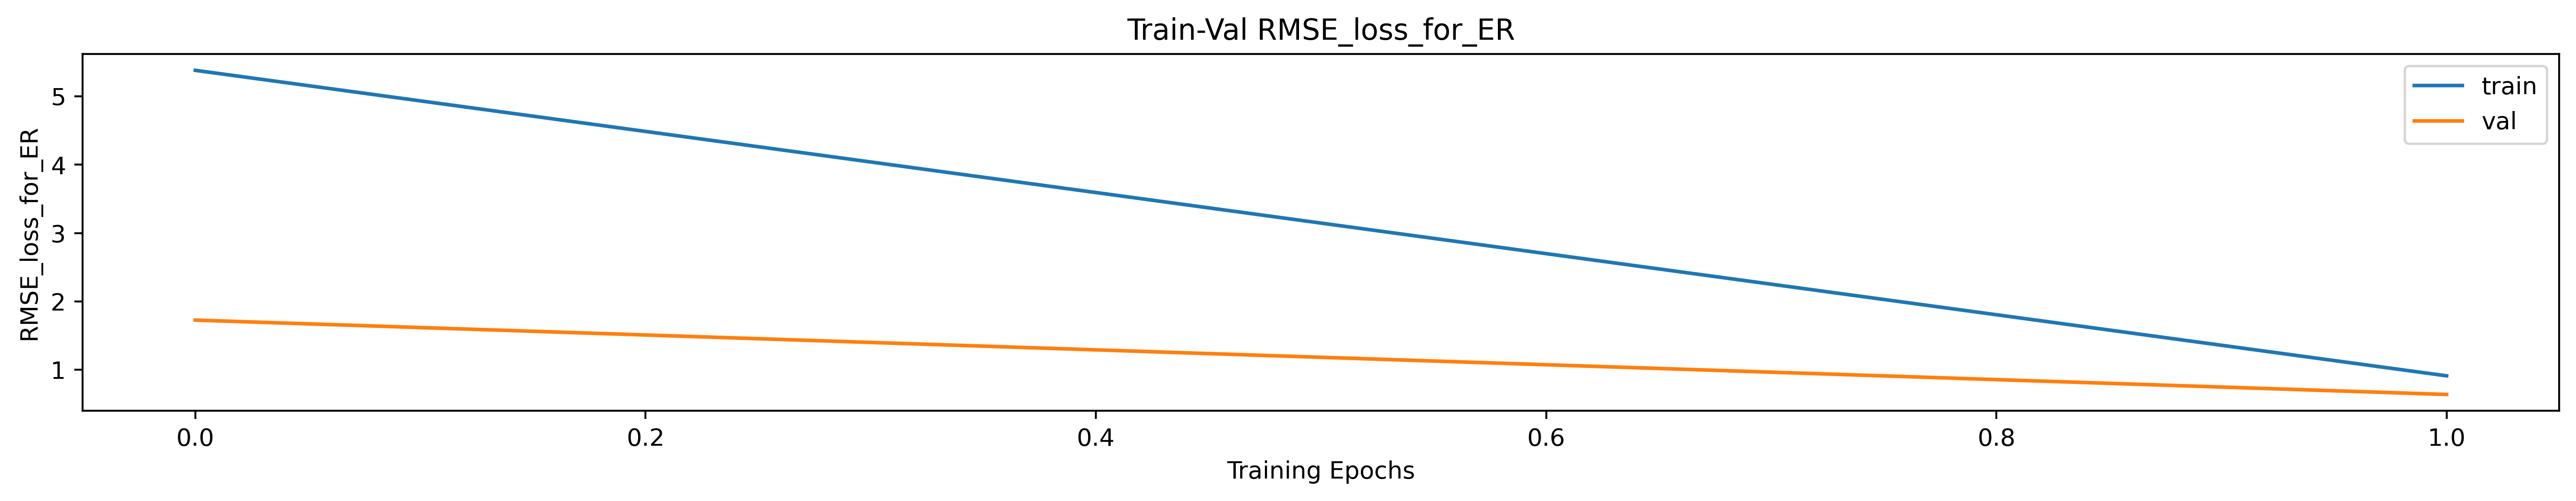

In [4]:
stage = "Pretrain_1"

# model training
for epoch in range(T4.args.epochs):
    trainer.train(epoch, stage)
    val_loss = trainer.valid(epoch, stage)

# train log image save
trainer.evaluate('RMSE_loss_for_ER')

T4sigWGAN EP_valid:1: 100%|| 2/2 [00:02<00:00,  1.15s/it]


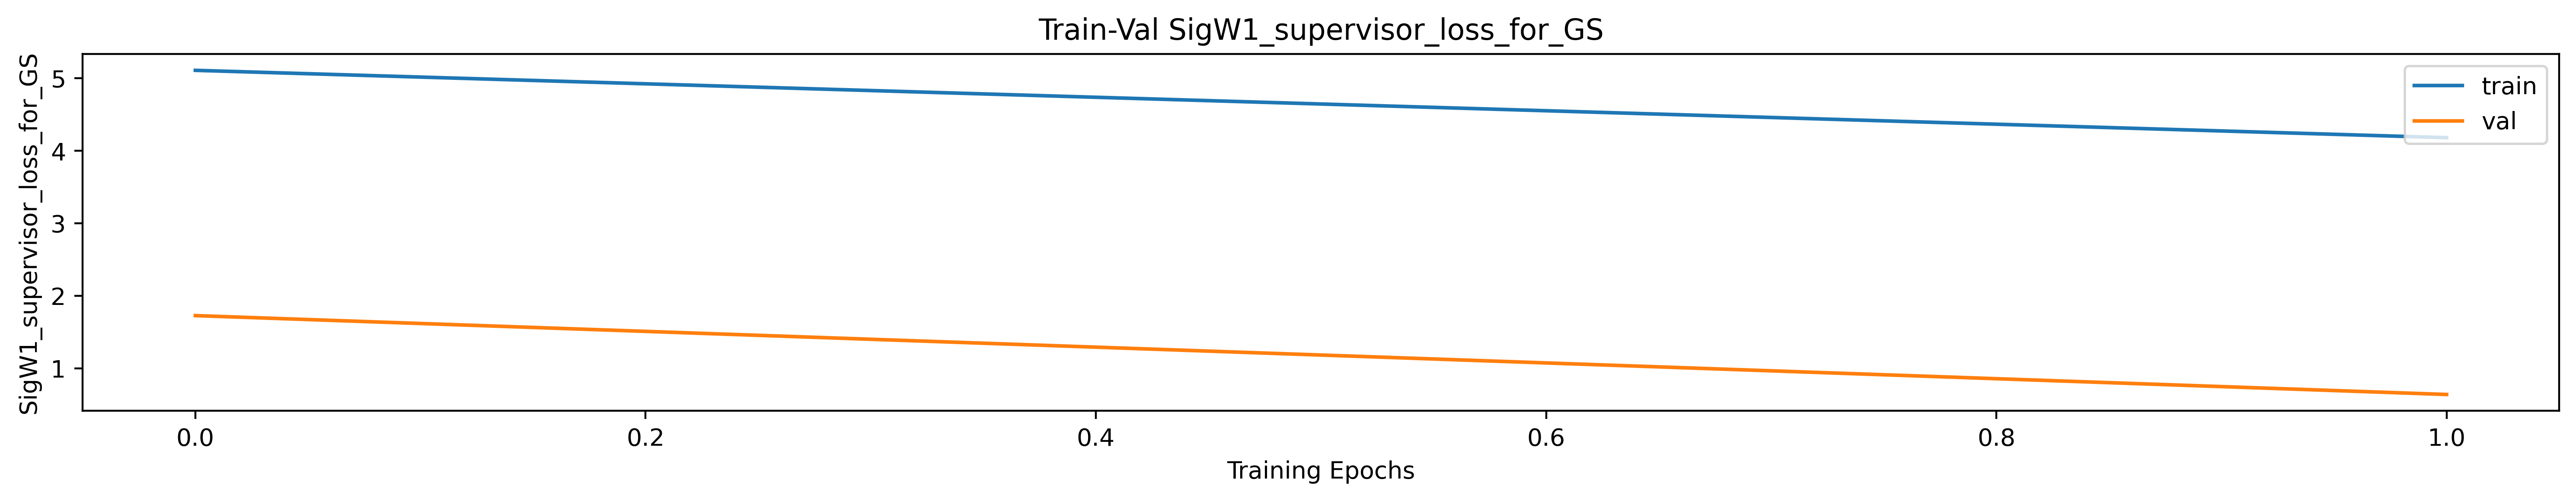

In [5]:
stage = "Pretrain_2"

# model training
for epoch in range(T4.args.epochs):
    trainer.train(epoch, stage)
    val_loss = trainer.valid(epoch, stage)

# train log image save
trainer.evaluate('SigW1_supervisor_loss_for_GS')

T4sigWGAN EP_valid:1: 100%|| 2/2 [00:02<00:00,  1.36s/it]


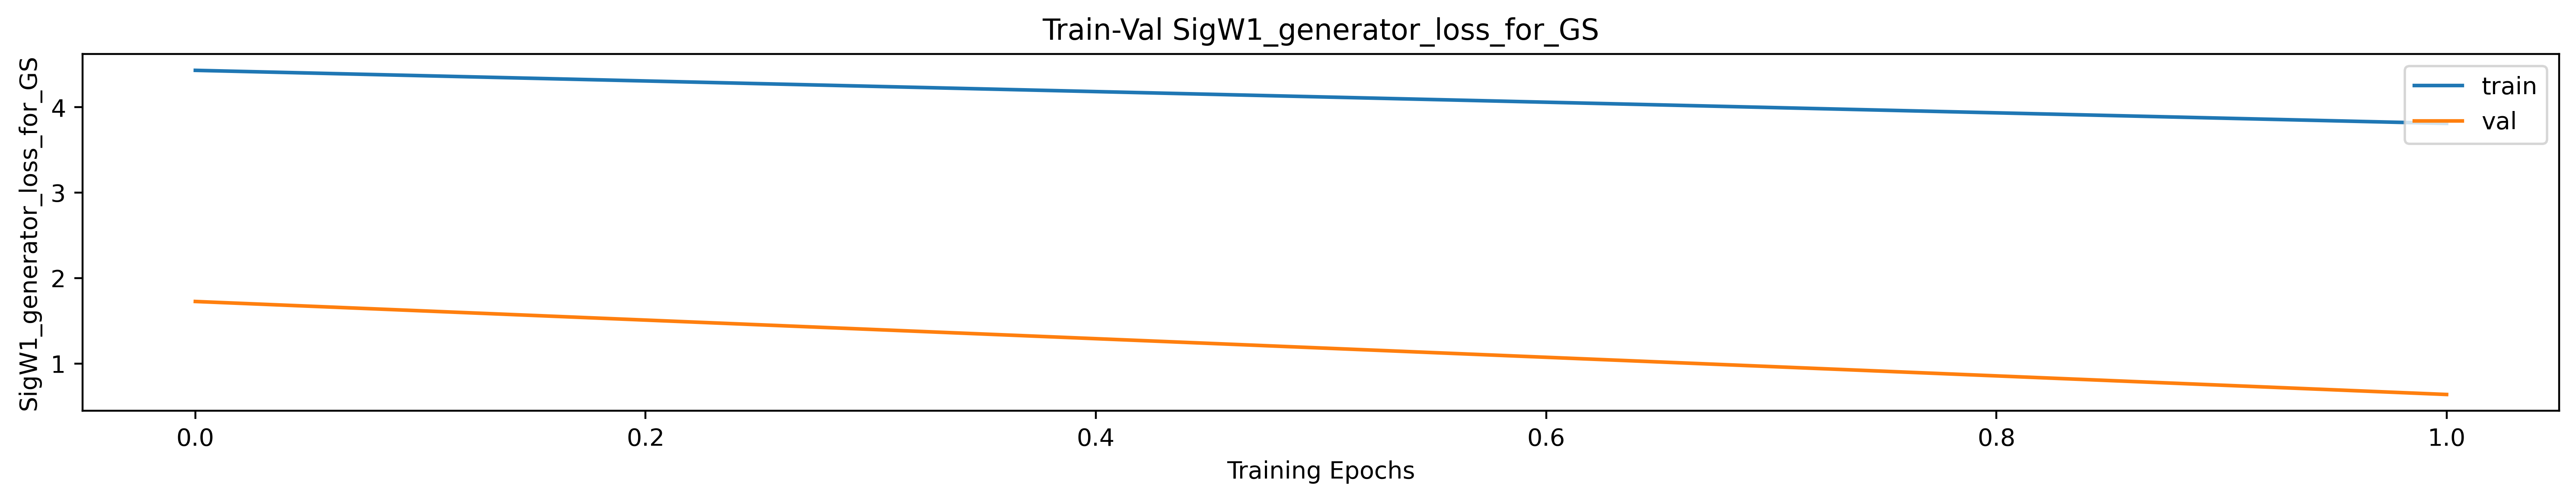

In [6]:
stage = "Finetune"

# model training
for epoch in range(T4.args.epochs):
    trainer.train(epoch, stage)
    val_loss = trainer.valid(epoch, stage)

# train log image save
trainer.evaluate('SigW1_generator_loss_for_GS')

In [7]:
trainer.save()

In [9]:
x_fake = model(600)

In [11]:
x_fake.shape

(600, 60, 10)

In [19]:
total_dataset[1].detach().cpu().numpy()[:, 1]

array([ 0.01083493,  0.04476671,  0.00603503,  0.01229754,  0.00059261,
        0.02013622, -0.00609576, -0.00554914, -0.02995596,  0.00847722,
        0.0027019 , -0.01766467,  0.0237732 ,  0.01607624,  0.00791094,
       -0.00348845, -0.0070011 , -0.00969453, -0.00059331,  0.02344912,
       -0.00783064,  0.01812344,  0.00430657,  0.00057177,  0.00457142,
        0.00369741, -0.0303202 , -0.0067212 , -0.00912037, -0.00059384,
        0.00297084,  0.00444317, -0.02123271, -0.00421812, -0.00363083,
       -0.02399031, -0.00093338, -0.0052943 ,  0.02629925, -0.01311776,
        0.00587334,  0.02980939,  0.01193678,  0.02241222, -0.02393995,
        0.        ,  0.00709225,  0.00205398,  0.00351388, -0.00641964,
        0.00469897, -0.00116928,  0.01141362,  0.00983797, -0.01146136,
       -0.01478256, -0.02559584,  0.01388898, -0.00863612, -0.00210272],
      dtype=float32)

In [14]:
x_fake[1][:, 1]

array([ 0.5601566 ,  0.62842244, -0.6259976 , -0.66339135, -0.49384716,
        0.6575048 ,  0.6474414 ,  0.69294655, -0.6757673 ,  0.6511049 ,
       -0.72595215, -0.7047386 ,  0.6569201 , -0.6271856 , -0.5678335 ,
       -0.71381295, -0.6518157 , -0.6112439 ,  0.6579178 ,  0.66358805,
       -0.6070206 ,  0.65434813,  0.4977153 , -0.68610495, -0.7072749 ,
       -0.67696047, -0.7212025 ,  0.7575902 , -0.6573665 , -0.65947413,
       -0.5024936 ,  0.6377852 ,  0.5858205 ,  0.6771879 , -0.5886644 ,
        0.6318675 ,  0.62661994, -0.6410876 , -0.5861349 , -0.6678097 ,
        0.59806323, -0.64903915,  0.73491055, -0.7045214 ,  0.54424036,
        0.6400572 ,  0.6868456 , -0.5735294 ,  0.6731218 ,  0.60566753,
       -0.6586307 ,  0.69190025,  0.67031676,  0.6179814 ,  0.7577679 ,
        0.7343986 , -0.6423244 ,  0.7812433 , -0.59588075, -0.6491916 ],
      dtype=float32)

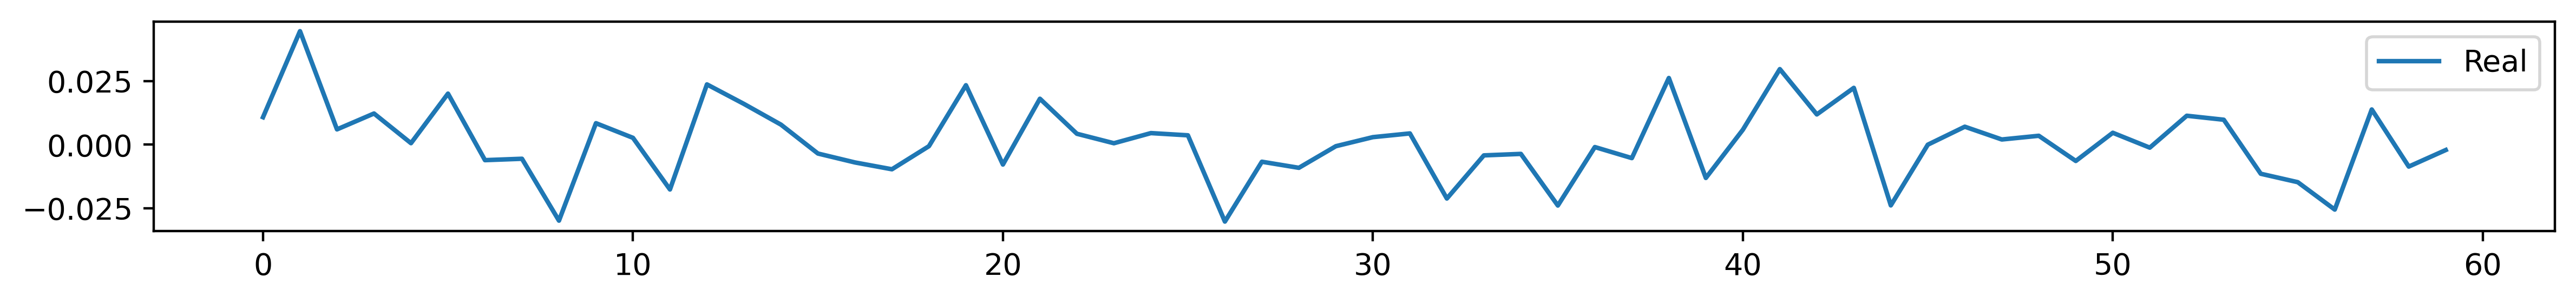

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 1.5), dpi=400)
plt.plot(x_fake[1][:, 1], label="Fake")
plt.plot(total_dataset[1].detach().cpu().numpy()[:, 1], label="Real")
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()

In [ ]:
# metric_iteration = 5
#
# discriminative_score = list()
# for _ in range(metric_iteration):
#     temp_disc = T4.discriminative_score_metrics(ori_data, generated_data)
#     discriminative_score.append(temp_disc)
#
# print('Discriminative score: ' + str(np.round(np.mean(discriminative_score), 4)))
#
#
# predictive_score = list()
# for tt in range(metric_iteration):
#     temp_pred = T4.predictive_score_metrics(ori_data, generated_data)
#     predictive_score.append(temp_pred)
#
# print('Predictive score: ' + str(np.round(np.mean(predictive_score), 4)))
#
#
# T4.visualization(ori_data, generated_data, 'pca')
# T4.visualization(ori_data, generated_data, 'tsne')